In [ ]:
pip install ctgan

In [ ]:
pip install scikit-learn

In [ ]:
pip install -U imbalanced-learn

In [ ]:
pip install h2o

In [ ]:
pip install pyro-ppl

In [ ]:
!pip install plotly>=4.7.1
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
# Import packages
# https://medium.com/pursuitnotes/multiple-linear-regression-model-in-7-steps-with-python-c6f40c0a527
# https://scikit-learn.org/stable/inspection.html
# https://www.notion.so/Students-Notes-2f5f1b34045f49cab8c8479871a99f12

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from collections import Counter
from scipy import interp
from scipy.stats import norm
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, f1_score, accuracy_score,recall_score
from sklearn import datasets, metrics, model_selection, svm
from sklearn.datasets import make_classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.inspection import plot_partial_dependence
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from ctgan import CTGANSynthesizer
import plotly.express as px
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util  # patches torchvision
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import csv
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from h2o.estimators.gbm import H2OGradientBoostingEstimator
import h2o
from tabulate import tabulate

**Data Upload & Processing**

In [ ]:
# loading dataset
dataset = pd.read_csv('Final_Input.csv')
all_policies = (dataset.iloc[:, :].values).astype(np.float)

# assigning bucket values to categorical variables based on their score
cat_calc = all_policies[:,0:6]
cat_calc[cat_calc < 0.2] = 1 
cat_calc[cat_calc < 0.4] = 2 
cat_calc[cat_calc < 0.6] = 3 
cat_calc[cat_calc < 0.8] = 4 
cat_calc[cat_calc < 1.0] = 5

# normalising between zero and one to match continous variables scale
all_policies[:,0:6] = cat_calc/5

# creating test and hold out set
all_policies_copy = np.copy(all_policies)
X_original, X_hold_out, Y_original, Y_hold_out = train_test_split(all_policies_copy[:,:-1], all_policies_copy[:,-1], test_size=0.2, random_state=0)
original_policies = np.append(X_original,np.expand_dims(Y_original,1),axis=1)
hold_out_policies = np.append(X_hold_out,np.expand_dims(Y_hold_out,1),axis=1)

# creating subset array of claim policies only and non claim policies only
index = np.where(original_policies[:,-1] == 1)
claim_policies = original_policies[index[0],:]
index = np.where(original_policies[:,-1] == 0)
non_claim_policies = original_policies[index[0],:]

**Synthetic Data Generation**

Method 1

In [ ]:
# METHOD 1 - undersample

def undersample(original_policies):
  # divide original data into main training set and test set to remain seperate
  X_main, X_final_test, Y_main, Y_final_test = train_test_split(original_policies[:,:-1], original_policies[:,-1], test_size=0.2, random_state=0)

  # undersample majority class in training and test sets and shuffle
  with warnings.catch_warnings():
      warnings.filterwarnings("ignore")

      undersample = RandomUnderSampler(sampling_strategy=0.2)
      X_train, Y_train = undersample.fit_resample(X_main, Y_main)
      shuffle = np.arange((X_train.shape[0]))
      np.random.shuffle(shuffle)
      X_train = X_train[shuffle,:]
      Y_train = Y_train[shuffle]

      shuffle = np.arange((X_final_test.shape[0]))
      np.random.shuffle(shuffle)
      X_final_test = X_final_test[shuffle,:]
      Y_final_test = Y_final_test[shuffle]

      print(sorted(Counter(Y_train).items()))
      print(sorted(Counter(Y_final_test).items()))

  return X_train, Y_train, X_final_test, Y_final_test

In [ ]:
X_train, Y_train, X_final_test, Y_final_test = undersample(original_policies)

[(0.0, 375), (1.0, 75)]
[(0.0, 1115), (1.0, 19)]


Method 2

In [ ]:
# METHOD 2 - create synthetic claim policies using CTGAN
# https://github.com/sdv-dev/CTGAN & https://arxiv.org/pdf/1907.00503.pdf

def CTGAN(original_policies):
  # divide original data into main training set and test set to remain seperate
  X_main, X_final_test, Y_main, Y_final_test = train_test_split( original_policies[:,:-1], original_policies[:,-1], test_size=0.2, random_state=0)

  with warnings.catch_warnings():
      warnings.filterwarnings("ignore")

      # undersample majority class in training set in preperation for data synthesis
      undersample = RandomUnderSampler(sampling_strategy=0.2)
      X_resampled, y_resampled = undersample.fit_resample(X_main, Y_main)
      resampled_data = np.append(X_resampled,np.expand_dims(y_resampled,axis = 1),axis=1)

      # undersample majority class in test set and shuffle
      shuffle = np.arange((X_final_test.shape[0]))
      np.random.shuffle(shuffle)
      X_final_test = X_final_test[shuffle,:]
      Y_final_test = Y_final_test[shuffle]

  # identify claim and non claim policies in training set and create seperate arrays for each
  index = np.where(resampled_data[:,-1] == 1)
  temp_claim_policies = resampled_data[index[0],:]
  index = np.where(resampled_data[:,-1] == 0)
  temp_non_claim_policies = resampled_data[index[0],:]

  # Indices of the columns that are discrete
  discrete_columns = [0,1,2,3,4,5,(temp_claim_policies.shape[1]-1)]

  # Synthetic copy 
  with warnings.catch_warnings():
      warnings.filterwarnings("ignore")
      ctgan = CTGANSynthesizer(epochs=300)
      ctgan.fit(temp_claim_policies, discrete_columns)
      synthetic_data = ctgan.sample(75)
  
  # append synthetic claim polcies to original non claim policies
  data = np.append(temp_non_claim_policies,synthetic_data,axis=0)
  data = np.append(data,temp_claim_policies,axis=0)
  
  # shuffle data and split into X and Y
  np.random.shuffle(data)
  X_train = data[:, : -1]
  Y_train = data[:, -1]

  print(sorted(Counter(Y_train).items()))
  print(sorted(Counter(Y_final_test).items()))

  return X_train, Y_train, X_final_test, Y_final_test

In [ ]:
X_train, Y_train, X_final_test, Y_final_test = CTGAN(original_policies)

[(0.0, 375), (1.0, 150)]
[(0.0, 1115), (1.0, 19)]


Method 3

In [ ]:
# METHOD 3: over sample from claim policies using SMOTE to create more balanced data set
# https://imbalanced-learn.org/stable/over_sampling.html#naive-random-over-sampling & https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/ 

def Smote_function(original_policies,test_sample_mix = 0.1):
  # divide original data into main training set and test set to remain seperate
  X_main, X_final_test, Y_main, Y_final_test = train_test_split( original_policies[:,:-1], original_policies[:,-1], test_size=0.2, random_state=0)

  # undersample majority class in training and test sets
  with warnings.catch_warnings():
      warnings.filterwarnings("ignore")

      undersample = RandomUnderSampler(sampling_strategy=0.2)
      X_resampled, y_resampled = undersample.fit_resample(X_main, Y_main)

      # shuffle test set
      shuffle = np.arange((X_final_test.shape[0]))
      np.random.shuffle(shuffle)
      X_final_test = X_final_test[shuffle,:]
      Y_final_test = Y_final_test[shuffle]

  # oversample minority class
  with warnings.catch_warnings():
      warnings.filterwarnings("ignore")

      X_train, Y_train = SMOTE(sampling_strategy=0.4).fit_resample(X_resampled, y_resampled)
      shuffle = np.arange((X_train.shape[0]))
      np.random.shuffle(shuffle)
      X_train = X_train[shuffle,:]
      Y_train = Y_train[shuffle]

      print(sorted(Counter(Y_train).items()))
      print(sorted(Counter(Y_final_test).items()))
  
  return X_train, Y_train, X_final_test, Y_final_test

In [ ]:
X_train, Y_train, X_final_test, Y_final_test = Smote_function(original_policies,test_sample_mix = 1)

[(0.0, 375), (1.0, 150)]
[(0.0, 1115), (1.0, 19)]


Method 4

In [ ]:
# METHOD 4: VAE
# training a variational auto encoder based on keras tutorial https://blog.keras.io/building-autoencoders-in-keras.html

def VAE_synthesise(original_policies):
  # divide original data into main training set and test set to remain seperate
  X_main, X_final_test, Y_main, Y_final_test = train_test_split( original_policies[:,:-1], original_policies[:,-1], test_size=0.2, random_state=0)

  # undersample majority class 
  with warnings.catch_warnings():
      warnings.filterwarnings("ignore")

      undersample = RandomUnderSampler(sampling_strategy=0.2)
      X_resampled, y_resampled = undersample.fit_resample(X_main, Y_main)
      resampled_data = np.append(X_resampled,np.expand_dims(y_resampled,axis = 1),axis=1)

      # shuffle test data
      shuffle = np.arange((X_final_test.shape[0]))
      np.random.shuffle(shuffle)
      X_final_test = X_final_test[shuffle,:]
      Y_final_test = Y_final_test[shuffle]

  # identify claim and non claim policies in training set and create seperate arrays for each
  index = np.where(resampled_data[:,-1] == 1)
  temp_claim_policies = resampled_data[index[0],:].astype(np.single)
  index = np.where(resampled_data[:,-1] == 0)
  temp_non_claim_policies = resampled_data[index[0],:]

  # set up variables for VAE
  original_dim = original_policies.shape[1] - 1
  intermediate_dim = 10
  latent_dim = 4

  inputs = keras.Input(shape=(original_dim,))
  h = layers.Dense(intermediate_dim, activation='relu')(inputs)
  z_mean = layers.Dense(latent_dim)(h)
  z_log_sigma = layers.Dense(latent_dim)(h)

  # define sampling function
  def sampling(args):
      z_mean, z_log_sigma = args
      epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=0.1)
      return z_mean + K.exp(z_log_sigma) * epsilon

  z = layers.Lambda(sampling)([z_mean, z_log_sigma])

  # Create encoder
  encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

  # Create decoder
  latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
  x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
  outputs = layers.Dense(original_dim, activation='sigmoid')(x)
  decoder = keras.Model(latent_inputs, outputs, name='decoder')

  # instantiate VAE model
  outputs = decoder(encoder(inputs)[2])
  vae = keras.Model(inputs, outputs, name='vae_mlp')

  reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)
  reconstruction_loss *= original_dim
  kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  vae_loss = K.mean(reconstruction_loss + kl_loss)
  vae.add_loss(vae_loss)
  vae.compile(optimizer='adam')

  # fit VAE
  vae.fit(temp_claim_policies[:,:-1], temp_claim_policies[:,:-1],epochs=750,batch_size=20)

  # create new synthetic policies
  data = np.copy(resampled_data)
  n = 3
  grid_x = np.linspace(-1, 1, n)
  grid_y = np.linspace(-1, 1, n)
  grid_z = np.linspace(-1, 1, n)
  grid_t = np.linspace(-1, 1, n)

  synthetic_data = np.zeros((n**4,original_policies.shape[1]-1))

  k = 0
  for i, yi in enumerate(grid_x):
      for j, xi in enumerate(grid_y):
        for z, zi in enumerate(grid_z):
          for t, ti in enumerate(grid_t):
            z_sample = np.array([[xi, yi, zi, ti]])
            x_decoded = decoder.predict(z_sample)
            synthetic_data[k,:] = x_decoded[0]
            k += 1

  # append to original data
  synthetic_data = np.append(synthetic_data,np.ones((synthetic_data.shape[0],1)),axis=1)
  data = np.append(resampled_data,synthetic_data,axis=0)

  # shuffle
  np.random.shuffle(data)
  X_train = data[:, : -1]
  Y_train = data[:, -1]

  return X_train, Y_train, X_final_test, Y_final_test

In [ ]:
X_train, Y_train, X_final_test, Y_final_test = VAE_synthesise(original_policies)

In [ ]:
  print(sorted(Counter(Y_train).items()))
  print(sorted(Counter(Y_final_test).items()))

[(0.0, 750), (1.0, 331)]
[(0.0, 1115), (1.0, 19)]


**PCA Analysis**

[0.2167357  0.13727748 0.1090954  0.0834528  0.0760339  0.07289891
 0.07046366 0.06768415 0.05284444 0.03452628]
0.9210127211113761


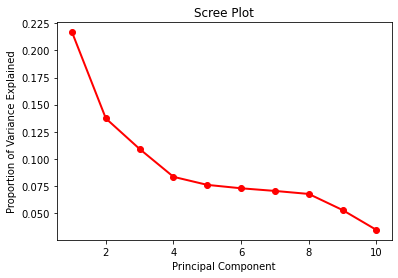

In [ ]:
# plotting principal compnent against proportion of variance explained
# https://blog.bioturing.com/2018/06/18/how-to-read-pca-biplots-and-scree-plots/

pca = PCA(n_components=10)
pca.fit(all_policies[:,:-1])
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

# https://www.datasklr.com/principal-component-analysis-and-factor-analysis/principal-component-analysis

PC_values = np.arange(pca.n_components_) + 1

# plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.savefig('PCA.png')

In [ ]:
# Plot principal components against each other - https://plotly.com/python/pca-visualization/

undersample = RandomUnderSampler(sampling_strategy=1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    X_PCA, y_PCA = undersample.fit_resample(original_policies[:,:-1], original_policies[:,-1])

# fit and transform pca
features = ["1", "2", "3"]
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(X_PCA)
components = pca.fit_transform(X_PCA)
labels = y_PCA.T 

# plot graphs
fig = px.scatter_matrix(components,labels=labels,dimensions=range(n_components),color=labels)
fig.update_traces(diagonal_visible=False)
fig.write_image("PCA_plot.png")
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:79: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



**Supervised Algorithms**

Sklearn algorithms

In [ ]:
def classification(probs,c):
  preds = np.zeros((len(probs)))
  i = 0
  while i < len(probs):
    if probs[i] < c:
      preds[i] = 0
    else:
      preds[i] = 1
    i += 1
  return preds

In [ ]:
# iterate through series of classifers, training and then applying to test set
# https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html

# under sampling or data synthesisers to use to balance data
data_generators = [undersample, CTGAN, Smote_function,VAE_synthesise]

# machine learning algorithms to test
names = ["Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree",
         "Random Forest", "AdaBoost"]
classifiers = [
    LogisticRegression(class_weight='balanced'),
    SVC(kernel="linear", C=1, class_weight='balanced'),
    SVC(gamma='scale', C=1, class_weight='balanced'), 
    Perceptron(class_weight='balanced'),
    DecisionTreeClassifier(), 
    RandomForestClassifier(), 
    AdaBoostClassifier()]

# number of splits for cross validation
n_splits = 5

# creating arrays to store output performance metrics
f1_train = np.zeros((len(classifiers),n_splits,len(data_generators)))
f1_val = np.zeros((len(classifiers),n_splits,len(data_generators)))
f1_test = np.zeros((len(classifiers),1,len(data_generators)))

AUC_train = np.zeros((len(classifiers),n_splits,len(data_generators)))
AUC_val = np.zeros((len(classifiers),n_splits,len(data_generators)))
AUC_test = np.zeros((len(classifiers),1,len(data_generators)))

acc_train = np.zeros((len(classifiers),n_splits,len(data_generators)))
acc_val = np.zeros((len(classifiers),n_splits,len(data_generators)))
acc_test = np.zeros((len(classifiers),1,len(data_generators)))

recall_train = np.zeros((len(classifiers),n_splits,len(data_generators)))
recall_val = np.zeros((len(classifiers),n_splits,len(data_generators)))
recall_test = np.zeros((len(classifiers),1,len(data_generators)))

# iterate through each data syntheiser function
g = 0
for gen in data_generators:
  print(gen)

  # use data synthesiser function to set up training and test data sets
  X_train, Y_train, X_final_test, Y_final_test = gen(original_policies)

  # iterate through each machine learning algorithm
  i = 0
  for name, clf in zip(names, classifiers):
    j = 0

    # create split function to divide data between training and validation sets
    rs = ShuffleSplit(n_splits=n_splits, random_state=0, test_size=0.2, train_size=None)

    # perform n_splits cross validation runs on the training data
    for train_index, test_index in rs.split(X_train):
      X_t = X_train[train_index]
      Y_t = Y_train[train_index] 
      X_val = X_train[test_index]
      Y_val = Y_train[test_index] 

      # fit the machine learning algorithm to the training data
      clf.fit(X_t, Y_t)

      # make predictions on the training and validation sets
      preds_t = clf.predict(X_t)
      preds_val = clf.predict(X_val)

      # update performance metric arrays
      f1_train[i,j,g] = f1_score(Y_t,preds_t)
      f1_val[i,j,g] = f1_score(Y_val,preds_val)

      AUC_train[i,j,g] = roc_auc_score(Y_t,preds_t)
      AUC_val[i,j,g] = roc_auc_score(Y_val,preds_val)

      acc_train[i,j,g] = accuracy_score(Y_t,preds_t)
      acc_val[i,j,g] = accuracy_score(Y_val,preds_val)

      recall_train[i,j,g] = recall_score(Y_t,preds_t)
      recall_val[i,j,g] = recall_score(Y_val,preds_val)

      j += 1
    
    # fit on entire training set and make predictions on test set
    clf.fit(X_train, Y_train) 
    preds_test = clf.predict(X_final_test)

    # update test set performance metrics
    f1_test[i,0,g] = f1_score(Y_final_test,preds_test)
    AUC_test[i,0,g] = roc_auc_score(Y_final_test,preds_test)
    acc_test[i,0,g] = accuracy_score(Y_final_test,preds_test)
    recall_test[i,0,g] = recall_score(Y_final_test,preds_test)

    i += 1  
  g += 1     

Results

In [ ]:
# calculating AUC mean scores and standard deviation for training and validation sets

auc_table = np.empty((3,len(names),len(data_generators)))
auc_table[0,:,:] = np.mean(AUC_train,axis = 1) # train means
#f1_table[1,:,:] = np.std(f1_train,axis = 1) # train sd
auc_table[1,:,:] = np.mean(AUC_val,axis = 1) # val means
#f1_table[3,:] = np.std(f1_val,axis = 1) # val sd
auc_table[2,:,:] = AUC_test[:,0] # test score

auc_table = np.around(auc_table,decimals=2)

print("Undersampling")
print(tabulate(auc_table[:,:,0],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("CTGAN")
print(tabulate(auc_table[:,:,1],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("Smote")
print(tabulate(auc_table[:,:,2],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("VAE")
print(tabulate(auc_table[:,:,3],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))

Undersampling
  Logistic Regression    Linear SVM    RBF SVM    Perceptron    Decision Tree    Random Forest    AdaBoost
---------------------  ------------  ---------  ------------  ---------------  ---------------  ----------
                 0.74          0.73       0.77          0.68             1                1           0.92
                 0.72          0.66       0.69          0.62             0.66             0.64        0.66
                 0.74          0.77       0.75          0.8              0.61             0.7         0.78
CTGAN
  Logistic Regression    Linear SVM    RBF SVM    Perceptron    Decision Tree    Random Forest    AdaBoost
---------------------  ------------  ---------  ------------  ---------------  ---------------  ----------
                 0.76          0.75       0.81          0.73             1                1           0.96
                 0.74          0.73       0.75          0.73             0.82             0.86        0.83
                 

In [ ]:
# calculating f1 mean scores and standard deviation for training and validation sets

f1_table = np.empty((3,len(names),len(data_generators)))
f1_table[0,:,:] = np.mean(f1_train,axis = 1) # train means
#f1_table[1,:,:] = np.std(f1_train,axis = 1) # train sd
f1_table[1,:,:] = np.mean(f1_val,axis = 1) # val means
#f1_table[3,:] = np.std(f1_val,axis = 1) # val sd
f1_table[2,:,:] = f1_test[:,0] # test f1 score

f1_table = np.around(f1_table,decimals=2)

print("Undersampling")
print(tabulate(f1_table[:,:,0],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("CTGAN")
print(tabulate(f1_table[:,:,1],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("Smote")
print(tabulate(f1_table[:,:,2],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("VAE")
print(tabulate(f1_table[:,:,3],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))

Undersampling
  Logistic Regression    Linear SVM    RBF SVM    Perceptron    Decision Tree    Random Forest    AdaBoost
---------------------  ------------  ---------  ------------  ---------------  ---------------  ----------
                 0.46          0.45       0.49          0.42             1                1           0.89
                 0.45          0.39       0.42          0.35             0.43             0.42        0.43
                 0.07          0.07       0.07          0.16             0.08             0.32        0.21
CTGAN
  Logistic Regression    Linear SVM    RBF SVM    Perceptron    Decision Tree    Random Forest    AdaBoost
---------------------  ------------  ---------  ------------  ---------------  ---------------  ----------
                 0.64          0.63       0.72          0.6              1                1           0.96
                 0.64          0.62       0.64          0.61             0.73             0.83        0.76
                 

In [ ]:
# calculating accuracy mean scores and standard deviation for training and validation sets

acc_table = np.empty((3,len(names),len(data_generators)))
acc_table[0,:,:] = np.mean(acc_train,axis = 1) # train means
#acc_table[1,:,:] = np.std(acc_train,axis = 1) # train sd
acc_table[1,:,:] = np.mean(acc_val,axis = 1) # val means
#acc_table[3,:] = np.std(acc_val,axis = 1) # val sd
acc_table[2,:,:] = acc_test[:,0] # test acc score

acc_table = np.around(acc_table,decimals=2)

print("Undersampling")
print(tabulate(acc_table[:,:,0],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("CTGAN")
print(tabulate(acc_table[:,:,1],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("Smote")
print(tabulate(acc_table[:,:,2],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("VAE")
print(tabulate(acc_table[:,:,3],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))

Undersampling
  Logistic Regression    Linear SVM    RBF SVM    Perceptron    Decision Tree    Random Forest    AdaBoost
---------------------  ------------  ---------  ------------  ---------------  ---------------  ----------
                 0.69          0.66       0.7           0.63             1                1           0.97
                 0.68          0.62       0.67          0.61             0.8              0.85        0.83
                 0.64          0.6        0.61          0.87             0.85             0.97        0.92
CTGAN
  Logistic Regression    Linear SVM    RBF SVM    Perceptron    Decision Tree    Random Forest    AdaBoost
---------------------  ------------  ---------  ------------  ---------------  ---------------  ----------
                 0.77          0.77       0.83          0.79             1                1           0.98
                 0.76          0.75       0.77          0.79             0.84             0.91        0.86
                 

In [ ]:
# calculating recall mean scores and standard deviation for training and validation sets

recall_table = np.empty((3,len(names),len(data_generators)))
recall_table[0,:,:] = np.mean(recall_train,axis = 1) # train means
#recall_table[1,:,:] = np.std(recall_train,axis = 1) # train sd
recall_table[1,:,:] = np.mean(recall_val,axis = 1) # val means
#recall_table[3,:] = np.std(recall_val,axis = 1) # val sd
recall_table[2,:,:] = recall_test[:,0] # test recall score

recall_table = np.around(recall_table,decimals=2)

print("Undersampling")
print(tabulate(recall_table[:,:,0],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("CTGAN")
print(tabulate(recall_table[:,:,1],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("Smote")
print(tabulate(recall_table[:,:,2],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))
print("VAE")
print(tabulate(recall_table[:,:,3],headers = ("Logistic Regression", "Linear SVM", "RBF SVM","Perceptron","Decision Tree","Random Forest", "AdaBoost")))

Undersampling
  Logistic Regression    Linear SVM    RBF SVM    Perceptron    Decision Tree    Random Forest    AdaBoost
---------------------  ------------  ---------  ------------  ---------------  ---------------  ----------
                 0.81          0.85       0.88          0.76             1                1           0.85
                 0.78          0.72       0.72          0.65             0.45             0.31        0.39
                 0.84          0.95       0.89          0.74             0.37             0.42        0.63
CTGAN
  Logistic Regression    Linear SVM    RBF SVM    Perceptron    Decision Tree    Random Forest    AdaBoost
---------------------  ------------  ---------  ------------  ---------------  ---------------  ----------
                 0.73          0.71       0.79          0.59             1                1           0.94
                 0.7           0.67       0.69          0.59             0.75             0.75        0.74
                 

H2O algorithm

In [ ]:
# gradient boosting model from H2O run with data synthesis methods
# https://docs.h2o.ai/h2o/latest-stable/h2o-docs/booklets/GBMBooklet.pdf & https://docs.h2o.ai/h2o/latest-stable/h2o-docs/training-models.html 

h2o.init()

data_generators = [undersample, CTGAN, Smote_function, VAE_synthesise]

h2o_performance = np.empty((6,len(data_generators)))

i = 0
for gen in data_generators:
  # split between training and in-sample test set
  X_train, Y_train, X_final_test, Y_final_test = gen(original_policies)

  GBMdata_train = np.append(X_train,np.expand_dims(Y_train,axis=1),axis=1)
  GBMdata_test = np.append(X_final_test,np.expand_dims(Y_final_test,axis=1),axis=1)

  GBMdata_train = h2o.H2OFrame(GBMdata_train)
  GBMdata_train[(claim_policies.shape[1]-1)] = GBMdata_train[(claim_policies.shape[1]-1)].asfactor()
  GBMdata_test = h2o.H2OFrame(GBMdata_test)
  GBMdata_test[(claim_policies.shape[1]-1)] = GBMdata_test[(claim_policies.shape[1]-1)].asfactor()

  # training model
  air_model = H2OGradientBoostingEstimator(nfolds = 5,distribution = 'bernoulli',sample_rate = .7, seed = 1234)
  air_model.train(y = (claim_policies.shape[1]-1), training_frame = GBMdata_train)

  # making predictions and storing performance metrics
  pred_h2o = air_model.predict(GBMdata_test)
  pred_h2o = pred_h2o.as_data_frame().to_numpy()

  perf_train = air_model.model_performance(GBMdata_train)
  h2o_performance[0,i] = perf_train.auc()
  h2o_performance[1,i] = perf_train.F1()[0][1]

  perf_val = air_model.model_performance(GBMdata_train,xval = True)
  h2o_performance[2,i] = perf_val.auc()
  h2o_performance[3,i] = perf_val.F1()[0][1]

  perf_test = air_model.model_performance(GBMdata_test)
  h2o_performance[4,i] = perf_test.auc()
  h2o_performance[5,i] = perf_test.F1()[0][1]

  i += 1

In [ ]:
print(tabulate(h2o_performance,headers = ("undersample", "CTGAN", "Smote_function", "VAE_synthesise")))

  undersample     CTGAN    Smote_function    VAE_synthesise
-------------  --------  ----------------  ----------------
     0.998044  0.998791          0.999378          0.999538
     0.951724  0.976898          0.986755          0.987179
     0.998044  0.998791          0.999378          0.999538
     0.951724  0.976898          0.986755          0.987179
     0.89443   0.910786          0.920557          0.921029
     0.327273  0.304348          0.333333          0.358209


Neural Network

In [ ]:
# neural network from PyTorch
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(26, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
num_epochs = 500
learning_rate = 0.01
losstype = nn.CrossEntropyLoss()

data_generators = [undersample, CTGAN, Smote_function,VAE_synthesise]

nn_performance = np.empty((6,len(data_generators)))

j = 0
for gen in data_generators:
  # split between training and in-sample test set
  X_train, Y_train, X_final_test, Y_final_test = gen(original_policies)

  X_train = torch.from_numpy(X_train).type(torch.float)
  Y_train = torch.from_numpy(Y_train).type(torch.float)
  X_final_test = torch.from_numpy(X_final_test).type(torch.float)
  Y_final_test = torch.from_numpy(Y_final_test).type(torch.float)

  n_splits = 5

  # setting up performance metric tables
  f1_train_net = np.zeros((n_splits))
  f1_val_net = np.zeros((n_splits))
  f1_test_net = np.zeros((n_splits))

  ROC_train_net = np.zeros((n_splits))
  ROC_val_net = np.zeros((n_splits))
  ROC_test_net = np.zeros((n_splits))

  accuracy_train_net = np.zeros((n_splits))
  accuracy_val_net = np.zeros((n_splits))
  accuracy_test_net = np.zeros((n_splits))

  recall_train_net = np.zeros((n_splits))
  recall_val_net = np.zeros((n_splits))
  recall_test_net = np.zeros((n_splits))

  # cross validation
  rs = ShuffleSplit(n_splits=n_splits, random_state=0, test_size=0.2, train_size=None)
  i = 0
  for train_index, test_index in rs.split(X_train):
    X_t = X_train[train_index]
    Y_t = Y_train[train_index] 
    X_val = X_train[test_index]
    Y_val = Y_train[test_index] 

    net = Net()
    optimiser = torch.optim.Adam(net.parameters(),lr = learning_rate)

    for epoch in range(num_epochs):
      # back propagation
      ypred = net(X_t)
      _,prediction = torch.max(ypred,1)
      loss = losstype(ypred,Y_t.long())
      optimiser.zero_grad()
      loss.backward()
      optimiser.step()

    with torch.no_grad():
      # recording performance metrics
      accuracy_train_net[i] = (prediction == Y_t).sum().item()/len(Y_t)
      index = np.where(Y_t == 1)
      prediction_dummy = prediction[index[0]]
      Y_dummy = Y_t[index[0]]
      recall_train_net[i] = (prediction_dummy == Y_dummy).sum().item()/sum(Y_t)
      f1_train_net[i] = f1_score(Y_t, prediction)
      ROC_train_net[i] = roc_auc_score(Y_t,prediction)

      ypred_val = net(X_val)
      _,prediction_val = torch.max(ypred_val,1)
      accuracy_val_net[i] = (prediction_val == Y_val).sum().item()/len(Y_val)
      index = np.where(Y_val == 1)
      prediction_dummy = prediction_val[index[0]]
      Y_dummy = Y_val[index[0]]
      recall_val_net[i] = (prediction_dummy == Y_dummy).sum().item()/sum(Y_val)
      f1_val_net[i] = f1_score(Y_val, prediction_val)
      ROC_val_net[i] = roc_auc_score(Y_val, prediction_val)

      ypred_test = net(X_final_test)
      _,prediction_test = torch.max(ypred_test,1)
      accuracy_test_net[i] = (prediction_test == Y_final_test).sum().item()/len(Y_final_test)
      index = np.where(Y_final_test == 1)
      prediction_dummy = prediction_test[index[0]]
      Y_dummy = Y_final_test[index[0]]
      recall_test_net[i] = (prediction_dummy == Y_dummy).sum().item()/sum(Y_final_test)
      f1_test_net[i] = f1_score(Y_final_test, prediction_test)
      ROC_test_net[i] = roc_auc_score(Y_final_test, prediction_test)
    
    i += 1
  
  nn_performance[0,j] = np.mean(ROC_train_net)
  nn_performance[1,j] = np.mean(f1_train_net)
  nn_performance[2,j] = np.mean(ROC_val_net)
  nn_performance[3,j] = np.mean(f1_val_net)
  nn_performance[4,j] = np.mean(ROC_test_net)
  nn_performance[5,j] = np.mean(f1_test_net)

  j += 1

In [ ]:
print(tabulate(nn_performance,headers = ("undersample", "CTGAN", "Smote_function", "VAE_synthesise")))

  undersample     CTGAN    Smote_function    VAE_synthesise
-------------  --------  ----------------  ----------------
     0.696193  0.80553           0.868842          0.890851
     0.550837  0.74451           0.817461          0.857946
     0.659513  0.729236          0.783894          0.825207
     0.465072  0.617824          0.676554          0.751331
     0.649946  0.679198          0.682346          0.698338
     0.192567  0.154771          0.108364          0.147884


**Unsupervised Algorithms**

Local Density Approach

In [ ]:
# Calculating Euclidean distance between points and gaussian kernel matrix

X_train = original_policies[:,:-1]
Y_train = original_policies[:,-1]

cont_data = original_policies[:,6:]
EucDistance = np.zeros((cont_data.shape[0],cont_data.shape[0]))

i = 0
while i < cont_data.shape[0]:
    temp = cont_data[i,:] - cont_data
    dist = (np.sum((temp*temp),axis=1))**0.5
    EucDistance[i,:] = dist
    i += 1
Kernel = np.exp(-(EucDistance**2))

# knn is nearest neighbours of each policy, rnn is polcies that have a policy within their k nearest neighbours
k = 20
knn = np.zeros((cont_data.shape[0],k))
rnn = np.zeros((cont_data.shape[0],cont_data.shape[0]))
vertind = np.zeros((cont_data.shape[0])).astype(int)

i = 0
while i < cont_data.shape[0]:
  idx = (EucDistance[i,:]).argsort()[:k]
  knn[i,:] = idx # need to remove the point itself from nn, maybe extend to 11 point including?
  rnn[idx,vertind[idx]] = i
  vertind[idx] += 1
  i += 1
rnn = rnn[:,0:np.max(vertind)+1]

# snn is polcies that are in each others k nearest neighbours
snn = np.zeros((cont_data.shape[0],cont_data.shape[0]))
vi = np.zeros((cont_data.shape[0])).astype(int)

i = 0
while i < cont_data.shape[0]:
  j = 0
  while j < k:
    neighbour = int(knn[i,j])
    if i in knn[neighbour,:]:
      snn[i,vi[i]] = neighbour
      vi[i] += 1
    j += 1
  i += 1
snn = snn[:,0:np.max(vi)+1]
pXp = np.zeros((cont_data.shape[0]))

i = 0
while i < cont_data.shape[0]:
  nn = np.concatenate((knn[i,:],rnn[i,0:vertind[i]],snn[i,0:vi[i]])).astype(int)
  pxp = 0
  for j in nn:
    pxp += Kernel[i,j]/len(nn)
  pXp[i] = pxp
  i += 1

RDOS = np.zeros((cont_data.shape[0]))

i = 0
while i < cont_data.shape[0]:
  nn = np.concatenate((knn[i,:],rnn[i,0:vertind[i]],snn[i,0:vi[i]])).astype(int)
  rdos = 0
  for j in nn:
    rdos += pXp[j]/(len(nn)*pXp[i])
  RDOS[i] = rdos
  i += 1

In [ ]:
# performance metrics for local density algorithm

probs_kernel = classification(RDOS,np.percentile(RDOS,90))

accuracy_density = (probs_kernel == Y_train).sum().item()/len(Y_train)
index = np.where(Y_train == 1)
prediction_dummy = probs_kernel[index[0]]
Y_dummy = Y_train[index[0]]
recall_density = (prediction_dummy == Y_dummy).sum().item()/sum(Y_train)
f1_density = f1_score(Y_train, probs_kernel)
auc_density = roc_auc_score(Y_train, probs_kernel)

print("F1 score train", f1_density)
print("AUC train", auc_density)
print("accuracy score train", accuracy_density)
print("recall score train", recall_density)

F1 score train 0.08472012102874432
AUC train 0.6005780148206971
accuracy score train 0.8932415740250573
recall score train 0.2978723404255319


ODMAD

In [ ]:
# ODMAD algorithm 
# foreach point xi ( i = 1..n) begin Add the categorical values of xi , their frequencies, & their means to A;

from itertools import combinations
import collections

X_train = original_policies[:,:-1]
Y_train = original_policies[:,-1]

cat_data = X_train[:,0:6]
con_data = X_train[:,6:] 
cat_comb = {} # dictionary of different categorical variable combinations in the data set mapped to their frequency
max_len = 5 # maximum length of each variable combination
num_attributes = cat_data.shape[1] # number of categorical attributes
minsup = 200 # value is infrequent if it appears fewer than minsup times in data
A = np.zeros((cat_data.shape[0],num_attributes,3)) # storing frequency and mean for each individual catagorical variable value

# storing frequency and mean for each individual catagorical variable value
i = 0
while i < cat_data.shape[0]:
  A[i,:,0] = cat_data[i,:]
  j = 0
  while j < num_attributes:
    freqs = collections.Counter(cat_data[:,j]) # dictionary of frequency of each data value for attribute j
    freq = freqs[A[i,j,0]] # frequency of data value in data set
    mean = np.mean(cat_data[:,j]) # mean of all data values in data set
    A[i,j,1] = freq
    A[i,j,2] = mean
    j += 1

  # counting number of combinations of variables in data
  l = 2
  while l <= max_len:
    for comb in combinations(A[i,:,0],l): # number of different combinations of length l
      if comb not in cat_comb:
        cat_comb[comb] = 1
      else:
        cat_comb[comb] = cat_comb[comb] + 1
    l += 1
  i += 1

# updating dictionary to remove variable value combination with a frequency above minsup
keys = []
for key in cat_comb:
  if cat_comb[key] >= minsup: # value is infrequent if it appears less than minsup times in data
    keys.append(key)
for key in keys:
  cat_comb.pop(key)

In [ ]:
# ODMAD algorithm 
# calculating categorical score for each policy
score1 = np.zeros((cat_data.shape[0])) # to store score1 values for each data point
score2 = np.zeros((cat_data.shape[0]))
m = 0
n = 500 # number of points in calculation of average scores
window_score1 = np.zeros((n))
window_score2 = np.zeros((n))
delta_c = 10
delta_q = 0.2
cos_val = np.zeros((cat_data.shape[0],num_attributes)) # to store cos angles between vectors
low_sup = 100 # user-entered frequency threshold to indicate what values we consider ‘highly infrequent'. Exclude these points from the mean calculation
upper_sup = 5000 # applying an upper bound we limit the amount of data points to which we assign a score in the continuous domain.
outlier = np.zeros((cat_data.shape[0]))

i = 0
while i < cat_data.shape[0]:
  v1 = con_data[i,:] # vector of continuous variables of data point i
  j = 0
  while j < num_attributes:
    if A[i,j,1] < minsup: # if frequency of categorical variable is less than minsup
      score1[i] += 1/A[i,j,1] # adding 1 divided by frequency of categorical variable
    if low_sup < A[i,j,1] <= upper_sup:
      ind = np.where(A[:,j,1] == A[i,j,1]) # all data points that share the same value of the categorical variable
      # ind = np.delete(ind, np.where(ind == i)) # remove data point i from the indices as shouldn't be compared to itself
      av_vector = np.zeros((con_data.shape[1])) # mean vector of all vectors in set
      for p in ind[0]:
        v2 = con_data[p,:] # vector of continuous variables of data point p
        av_vector += v2/len(ind) # updating average vector with latest data point
      cos_val[i,j] = v1 @ av_vector / (np.linalg.norm(v1,ord = 2) * np.linalg.norm(av_vector, ord = 2)) # needs to update mean vector excluding points below low_sup
    j += 1
  score2[i] = np.sum(cos_val[i]) / num_attributes # sum across all categorical values for each data point
  l = 2
  while l <= max_len:
    for comb in combinations(A[i,:,0],l):
      try:
        score1[i] += 1 / (cat_comb[comb] * l)
      except:
        score1[i] += 0
    l += 1
  if score1[i] > delta_c * np.mean(window_score1[0:min(n,m+1)]):
    outlier[i] = 1
  elif score2[i] < delta_q * np.mean(window_score2[0:min(n,m+1)]):
    outlier[i] = 1
  else:
    pos = m % n
    window_score1[pos] = score1[i]
    window_score2[pos] = score2[i]
    m += 1
  i += 1

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
# ROC curve for my algorithms

accuracy_ODMAD = (outlier == Y_train).sum().item()/len(Y_train)
index = np.where(Y_train == 1)
prediction_dummy = outlier[index[0]]
Y_dummy = Y_train[index[0]]
recall_ODMAD = (prediction_dummy == Y_dummy).sum().item()/sum(Y_train)
f1_ODMAD = f1_score(Y_train, outlier)
ROC_ODMAD = roc_auc_score(Y_train, outlier)

print("F1 score train", f1_ODMAD)
print("AUC train", ROC_ODMAD)
print("accuracy score train", accuracy_ODMAD)
print("recall score train", recall_ODMAD)

F1 score train 0.03494721514379323
AUC train 0.5216030175886015
accuracy score train 0.5322039880007058
recall score train 0.5106382978723404


**Parameter Testing**

H2O GBM

In [ ]:
h2o.init()

data_generators = [VAE_synthesise]

learning_rate = [0.1]
number_trees = [200]
maximum_depth = [10]
minimum_rows = [5]

for gen in data_generators:

  # split into training and in-sample test sets
  X_train, Y_train, X_final_test, Y_final_test = gen(original_policies) 

  GBMdata_train = np.append(X_train,np.expand_dims(Y_train,axis=1),axis=1)
  GBMdata_test = np.append(X_final_test,np.expand_dims(Y_final_test,axis=1),axis=1)

  GBMdata_train = h2o.H2OFrame(GBMdata_train)
  GBMdata_train[(claim_policies.shape[1]-1)] = GBMdata_train[(claim_policies.shape[1]-1)].asfactor()
  GBMdata_test = h2o.H2OFrame(GBMdata_test)
  GBMdata_test[(claim_policies.shape[1]-1)] = GBMdata_test[(claim_policies.shape[1]-1)].asfactor()

  for lr in learning_rate:
    for nt in number_trees:
      for md in maximum_depth:
        for mr in minimum_rows:

          # define model and train
          air_model =  H2OGradientBoostingEstimator(nfolds = 5, distribution = 'bernoulli', sample_rate = .7, ntrees = nt, max_depth = md, min_rows = mr, learn_rate = lr, seed = 1234)
          air_model.train(y = (claim_policies.shape[1]-1), training_frame = GBMdata_train)

          # predictions and performance on test set
          pred_h2o = air_model.predict(GBMdata_test)
          perf_test = air_model.model_performance(GBMdata_test)

          print("learning rate", lr, "number trees", nt, "maximum depth", md, "minimum rows", mr, "AUC", perf_test.auc() )

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 hour 50 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.7
H2O_cluster_version_age:,6 days
H2O_cluster_name:,H2O_from_python_unknownUser_9ammu1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.542 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Epoch 1/750
4/4 [==============================] - 1s 6ms/step - loss: 4.3302
Epoch 2/750
4/4 [==============================] - 0s 5ms/step - loss: 4.2725
Epoch 3/750
4/4 [==============================] - 0s 5ms/step - loss: 4.2085
Epoch 4/750
4/4 [==============================] - 0s 6ms/step - loss: 4.1515
Epoch 5/750
4/4 [==============================] - 0s 6ms/step - loss: 4.1087
Epoch 6/750
4/4 [==============================] - 0s 5ms/step - loss: 4.0677
Epoch 7/750
4/4 [==============================] - 0s 6ms/step - loss: 4.0290
Epoch 8/750
4/4 [==============================] - 0s 5ms/step - loss: 3.9764
Epoch 9/750
4/4 [==============================] - 0s 6ms/step - loss: 3.9443
Epoch 10/750
4/4 [==============================] - 0s 7ms/step - loss: 3.8970
Epoch 11/750
4/4 [==============================] - 0s 5ms/step - loss: 3.8620
Epoch 12/750
4/4 [==============================] - 0s 4ms/step - loss: 3.8220
Epoch 13/750
4/4 [==============================] - 0s 4ms/st

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%
<function VAE_synthesise at 0x7fcd716c4c20> AUC 0.8134395858025077


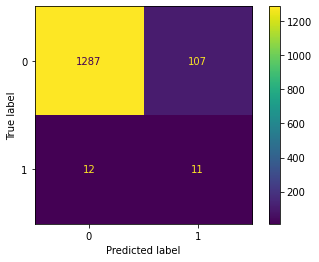

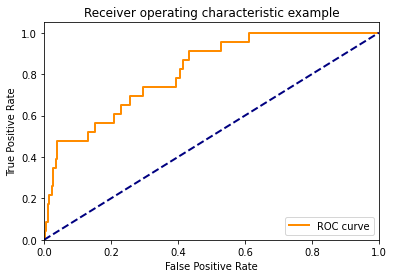

Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


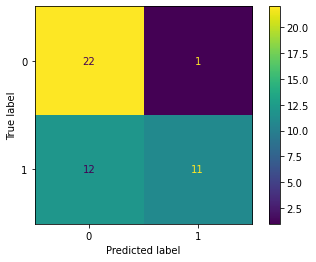

In [ ]:
# results on hold out test set
GBMdata_hold = h2o.H2OFrame(hold_out_policies)
GBMdata_hold[(claim_policies.shape[1]-1)] = GBMdata_hold[(claim_policies.shape[1]-1)].asfactor()
pred_h2o_hold = air_model.predict(GBMdata_hold)
perf_hold = air_model.model_performance(GBMdata_hold)

print(gen,"AUC", perf_hold.auc())

pred_h2o_hold = pred_h2o_hold.as_data_frame().to_numpy()
classification_h2o_hold = classification(pred_h2o_hold[:,2],0.3) # perf_hold.F1()[0][0]
cm_hold = confusion_matrix(Y_hold_out, classification_h2o_hold)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_hold, display_labels=[0,1])
disp.plot()

fpr_hold, tpr_hold, thresholds_hold = metrics.roc_curve(Y_hold_out, pred_h2o_hold[:,2], pos_label=1)
plt.figure()
lw = 2
plt.plot(fpr_hold, tpr_hold, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('GBM_ROC.png')
plt.show()

undersample = RandomUnderSampler(sampling_strategy=1)
X_holdout_bal, y_holdout_bal = undersample.fit_resample(X_hold_out, Y_hold_out)
holdout_bal = np.append(X_holdout_bal,np.expand_dims(y_holdout_bal,axis = 1),axis=1)

GBMdata_holdbal = h2o.H2OFrame(holdout_bal)
GBMdata_holdbal[(claim_policies.shape[1]-1)] = GBMdata_holdbal[(claim_policies.shape[1]-1)].asfactor()
pred_h2o_holdbal = air_model.predict(GBMdata_holdbal)
perf_holdbal = air_model.model_performance(GBMdata_holdbal)

pred_h2o_holdbal = pred_h2o_holdbal.as_data_frame().to_numpy()
classification_h2o_holdbal = classification(pred_h2o_holdbal[:,2],0.3) # perf_hold.F1()[0][0]
cm_holdbal = confusion_matrix(y_holdout_bal, classification_h2o_holdbal)
dispbal = ConfusionMatrixDisplay(confusion_matrix=cm_holdbal, display_labels=[0,1])
dispbal.plot()

In [ ]:
# performance metrics at different thresholds
print(perf_holdbal.auc())
F1_graph = perf_holdbal.F1(thresholds = [0.40,0.25,0.10,0.05,0.01,0.005,0.0025])
recall_graph = perf_holdbal.recall(thresholds = [0.40,0.25,0.10,0.05,0.01,0.005,0.0025])
precision_graph = perf_holdbal.precision(thresholds = [0.40,0.25,0.10,0.05,0.01,0.005,0.0025])
accuracy_graph = perf_holdbal.accuracy(thresholds = [0.40,0.25,0.10,0.05,0.01,0.005,0.0025])

performance_graphs = np.ndarray((7,5))

i = 0
while i < 7:
  performance_graphs[i,0] = F1_graph[i][0]
  performance_graphs[i,1] = F1_graph[i][1]
  performance_graphs[i,2] = recall_graph[i][1]
  performance_graphs[i,3] = precision_graph[i][1]
  performance_graphs[i,4] = accuracy_graph[i][1]
  i += 1

In [ ]:
performance_graphs

array([[0.4       , 0.62857143, 0.47826087, 0.91666667, 0.7173913 ],
       [0.25      , 0.61111111, 0.47826087, 0.84615385, 0.69565217],
       [0.1       , 0.57894737, 0.47826087, 0.73333333, 0.65217391],
       [0.05      , 0.61538462, 0.52173913, 0.75      , 0.67391304],
       [0.01      , 0.68292683, 0.60869565, 0.77777778, 0.7173913 ],
       [0.005     , 0.68292683, 0.60869565, 0.77777778, 0.7173913 ],
       [0.0025    , 0.68181818, 0.65217391, 0.71428571, 0.69565217]])

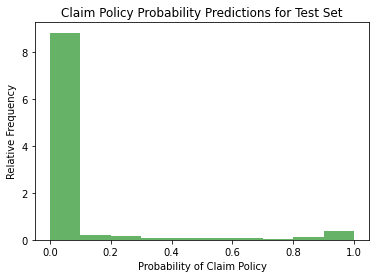

In [ ]:
# proabbility distribution of policies being a claim policy
plt.hist(pred_h2o_hold[:,2], bins=10, density=True, alpha=0.6, color='g')
plt.xlabel('Probability of Claim Policy')
plt.ylabel('Relative Frequency')
plt.title('Claim Policy Probability Predictions for Test Set')
plt.savefig(('prob_density.png'))

In [ ]:
# identifying false neagtive predictions for review
index = np.where(Y_hold_out != classification_h2o_hold)[0]
incorrect_predsx = X_hold_out[index,:]
incorrect_predsy = Y_hold_out[index]
index = np.where(incorrect_predsy == 1)[0]
incorrect_predsx = incorrect_predsx[index,:]
w = csv.writer(open("incorrect_preds.csv", "w"))
for i in incorrect_predsx:
  w.writerow(i)

In [ ]:
# comparing predictions against actual outcome
probs_table = np.empty((2,1417))
probs_table[0,:] = pred_h2o_hold[:,2]
probs_table[1,:] = Y_hold_out
print(tabulate(probs_table))

-----------  -----------  --------  -----------  -----------  -----------  -----------  --------  -----------  -----------  -----------  ----------  -----------  --------  -----------  --------  ----------  -----------  -----------  -----------  -----------  -----------  -----------  --------  ---------  -----------  -----------  --------  -----------  -----------  ----------  -----------  -----------  -----------  ----------  -----------  ----------  ---------  -----------  -----------  ----------  -----------  -----------  -----------  -----------  ----------  -----------  -----------  ---------  -----------  -----------  -----------  -----------  -----------  -----------  ---------  -----------  -------  -----------  -----------  -----------  -----------  ---------  ----------  --------  ---------  ----------  -----------  ----------  ---------  -----------  ----------  -----------  ---------  ---------  ----------  -----------  ----------  ----------  -----------  --------  -------

In [ ]:
index = np.where(probs_table[1,:] != 1)[0]
np.mean(probs_table[0,index])

0.06791542386186844

**Graphs for Thesis**

Partial Dependence

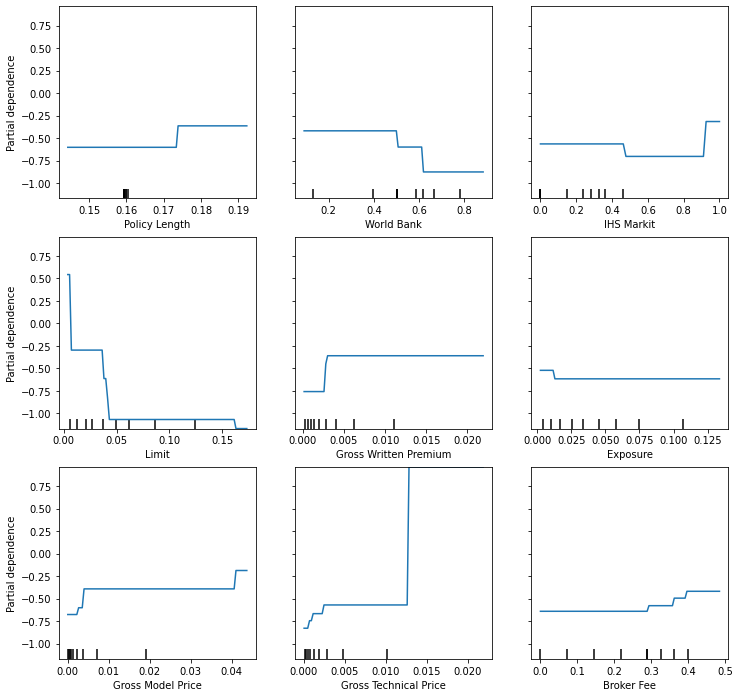

In [ ]:
# https://scikit-learn.org/stable/inspection.html

names = ["Placement","Sub-Class","Class Code","Leader Status","Broker","Years Held"
          ,"Policy Length","World Bank","IHS Markit","Limit","Gross Written Premium"
          ,"Exposure","Leader Line %","Excess","Deductible","PLR","RARC","Gross Model Price"
          ,"Gross Technical Price","Pricing Strength","Pricing Strength 2","Broker Fee"
          ,"Attachment","Model to Actual Ratio","Model to Technical Ratio","PLR ex Adj"]

# X{array-like or dataframe} of shape (n_samples, n_features)
mc_clf = GradientBoostingClassifier(n_estimators=100,max_depth=1).fit(original_policies[:,: -1], original_policies[:, -1])
features = [6,7,8,9,10,11,17,18,21] # The target features for which to create the PDPs
fig, ax = plt.subplots(figsize=(12, 12))
plot_partial_dependence(mc_clf, original_policies[:,: -1], features,ax = ax, feature_names = names) # target ignored in binary classification settings.
plt.savefig('partial_dependence.png')

# (6) World bank, (8) Limit, (9) GNWP, (10) GGWP, (15) PLR, (17) Gross Gross Model Price, (18) Gross Net Model Price, (19) Technical Price, (23) Broker Fee, (24) Attachment

In [ ]:
# training a variational auto encoder based on keras tutorial https://blog.keras.io/building-autoencoders-in-keras.html

original_dim = all_policies.shape[1] - 1
intermediate_dim = 10
latent_dim = 4

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

#reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss = keras.losses.mean_squared_error(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# fit the VAE
vae.fit(claim_policies[:,:-1], claim_policies[:,:-1],epochs=500,batch_size=20)

# create synthetic data
n = 2
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)
grid_z = np.linspace(-1, 1, n)
grid_t = np.linspace(-1, 1, n)

synthetic_data = np.zeros((n**4,all_policies.shape[1] - 1))

k = 0
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      for z, zi in enumerate(grid_z):
        for t, ti in enumerate(grid_t):
          z_sample = np.array([[xi, yi, zi, ti]])
          x_decoded = decoder.predict(z_sample)
          synthetic_data[k,:] = x_decoded[0]
          k += 1

In [ ]:
# comparing synthesised claim policies against actual claim policies

# CTGAN
#discrete_columns = [0,1,2,3,4,5,26]
#with warnings.catch_warnings():
#    warnings.filterwarnings("ignore")
#    ctgan = CTGANSynthesizer(epochs=50)
#    ctgan.fit(claim_policies, discrete_columns)
#    synthetic_data = ctgan.sample(100)

# SMOTE
#undersample = RandomUnderSampler(sampling_strategy=1)
#X_resampled, y_resampled = undersample.fit_resample(original_policies[:,: -1], original_policies[:,-1])
#X_synthetic, Y_synthetic = SMOTE().fit_resample(X_resampled, y_resampled)
#synthetic_data = np.append(X_synthetic,np.expand_dims(Y_synthetic,axis=1),axis=1)

# VAE
synthetic_data = np.append(synthetic_data,np.ones((synthetic_data.shape[0],1)),axis=1)

# All
# synthesised claim polcies are set to 0 label (dark blue)
dummy_synthetic_data = np.copy(synthetic_data)
index = np.where(dummy_synthetic_data[:,-1] == 1)
dummy_synthetic_data = dummy_synthetic_data[index[0],:]
dummy_synthetic_data[:,-1] = 0
mix_claim_policies = np.append(claim_policies[:,:-1],dummy_synthetic_data[:,:-1],axis=0)
mix_y = np.append(claim_policies[:,-1],dummy_synthetic_data[:,-1])

# undersample majority class to make graphical comparison easier 
undersample = RandomUnderSampler(sampling_strategy=1)
X_PCA, y_PCA = undersample.fit_resample(mix_claim_policies, mix_y)

shuffle = np.arange((X_PCA.shape[0]))
np.random.shuffle(shuffle)
X_PCA = X_PCA[shuffle,:]
y_PCA = y_PCA[shuffle]

# fit and transform PCA
features = ["1", "2", "3"]
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(mix_claim_policies)
components = pca.fit_transform(X_PCA)
labels = y_PCA.T 

# plot graphs
fig = px.scatter_matrix(components,labels=labels,dimensions=range(n_components),color=labels)
fig.update_traces(diagonal_visible=False)
fig.write_image("PCA_plot_VAE.png")
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/express/_core.py:79: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

